In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'RL.csv'
fr = pd.read_csv(FILE)

In [15]:
Vin = np.array(fr['Vin']) # V
VR = np.array(fr['VR']) # V
VL = np.array(fr['VL']) # V
ν = np.array(fr['Freq (kHz)']) * 10**3# Hz 
ω = 2*np.pi*ν
ΦR = np.array(fr['faseR (deg)'], dtype=np.float64) * (np.pi / 180) # rad
ΦL = np.array(fr['faseL (deg)'], dtype=np.float64) * (np.pi / 180) # rad

sigma_Vin = 0.04 / np.sqrt(12)
sigma_VR = np.array(fr['sigmaV_R']) / np.sqrt(12) #
sigma_VL = np.array(fr['sigmaV_L']) / np.sqrt(12)

R = 9950 # ohm
sigmaR = R * 0.01 # errore associato ohmmetro
RL = 40
sigmaRL = RL * 0.01

sigma_ΦR = np.array(fr['sigmaF_R'], dtype=np.float64) * (np.pi/180.0) / np.sqrt(12) # rad
sigma_ΦL = np.array(fr['sigmaF_L'], dtype=np.float64) * (np.pi/180.0) / np.sqrt(12) # rad

############# Calcolo funzioni di trasferimento #############

# calcolo funzione di trasferimento dal rapporto tra Vout/Vin

modHR = VR/Vin
sigma_modHR = np.sqrt(((VR/(Vin**2))*sigma_Vin)**2 + (sigma_VR/Vin)**2)

# calcolo H = Vout/Vin
modHL = VL/Vin
sigma_modHL = np.sqrt(((VL/(Vin**2))*sigma_Vin)**2 + (sigma_VL/Vin)**2)

### FUNZIONE DI TRASFERIMENTO $H_R(\omega)$:

- $|H_R(\omega)| = \frac{R}{\sqrt{(R+R_L)^2 + \omega^2 L^2}}$
- $\angle H_R(\omega) = -arctan(\frac{\omega L}{R+R_L})$

In [16]:
# definizione funzione modulo e argomento

def mod_HR_f(ω, L): # R noto
    num = R
    den2 = (R+RL)**2 + (ω**2) * (L**2)
    return num/np.sqrt(den2)

def arg_HR_f(ω,L):
    return -np.arctan((ω*L) / (R + RL))

In [17]:
# interpolazione

L_guess =0.04 # usa la resistenza fissata
fit_mod_HR = Interpolazione(ω,modHR,mod_HR_f,sigma_modHR,p0=[L_guess])
fit_arg_HR = Interpolazione(ω,ΦR,arg_HR_f,sigma_ΦR,p0=[L_guess])

print("---------------------------MODULO R-------------------------")
print('chi2: ',fit_mod_HR.rchisquare)
print("---------------------------FASE R-------------------------")
print('chi2: ',fit_arg_HR.rchisquare)
print('------------------------- VALORI RICAVATI DAL FIT MOD HR -----------------------------')
print('L = ',final_val(fit_mod_HR.bval[0],fit_mod_HR.sigma_bval[0],decimals=3,exp=-3,udm='Hr'))
print('------------------------- VALORI RICAVATI DAL FIT ARG HR -----------------------------')
print('L = ',final_val(fit_arg_HR.bval[0],fit_arg_HR.sigma_bval[0],decimals=3,exp=-3,udm='Hr'))

# print('R (nota) = ',final_val(R,sigmaR,decimals=3,exp=3,udm='Ω'))
# print('RL (nota) = ',final_val(RL,sigmaRL,decimals=3,exp=0,udm='Ω'))

---------------------------MODULO R-------------------------
chi2:  10.77
---------------------------FASE R-------------------------
chi2:  48.94
------------------------- VALORI RICAVATI DAL FIT MOD HR -----------------------------
L =  (49.29 ± 2.774)e-3 Hr
------------------------- VALORI RICAVATI DAL FIT ARG HR -----------------------------
L =  (53.998 ± 6.369)e-3 Hr


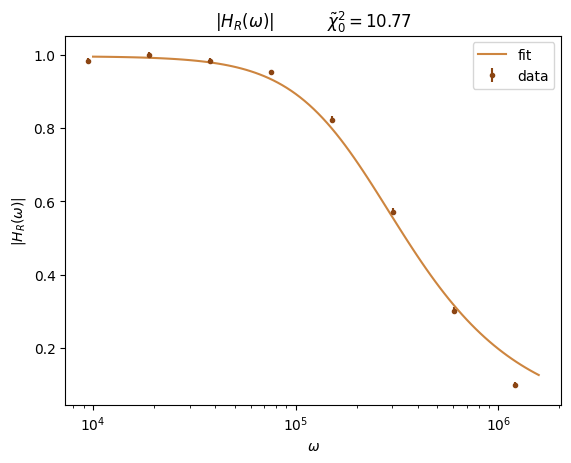

In [18]:
# rappressentazione modulo HR

x = np.logspace(4,6.2,100)
y = mod_HR_f(x,*fit_mod_HR.bval)

plt.title('$|H_R(\omega)|$ \t $\\tilde{\chi}_0^2=$' + str(fit_mod_HR.rchisquare))
plt.errorbar(ω,modHR,yerr=fit_mod_HR.sigmaY,fmt='.',label='data',color='saddlebrown')
plt.plot(x,y,label='fit',color='peru')
plt.xscale('log')
plt.ylabel('$|H_R(\omega)|$')
plt.xlabel('$\omega$')
plt.legend()
plt.show()

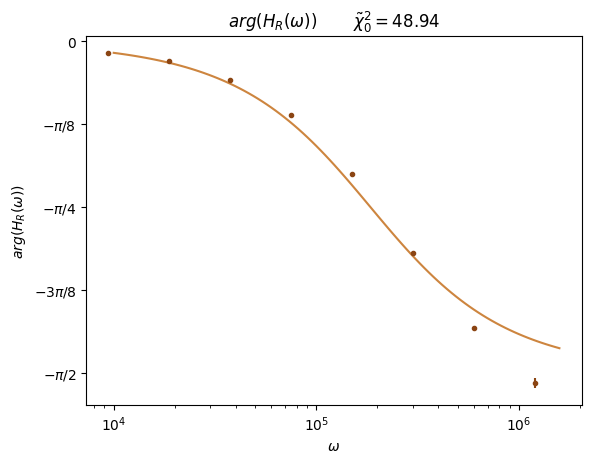

In [19]:
# rappresentazione argomento HR

x = np.logspace(4,6.2,100)
y = arg_HR_f(x,*fit_arg_HR.bval)

plt.title('$arg(H_R(\omega))$ \t $\\tilde{\chi}_0^2=$' + str(fit_arg_HR.rchisquare))
plt.errorbar(ω,ΦR,yerr=fit_arg_HR.sigmaY,fmt='.',color='saddlebrown',label='data')
plt.plot(x,y,color='peru',label='fit')
yticks = {'$-\pi/2$': -np.pi/2, '$-3\pi/8$': -3*np.pi/8, '$-\pi/4$': -np.pi/4, '$-\pi/8$': -np.pi/8,'0':0}
plt.yticks(list(yticks.values()), list(yticks.keys()))
plt.xscale('log')
plt.ylabel('$arg(H_R(\omega))$')
plt.xlabel('$\omega$')
plt.show()

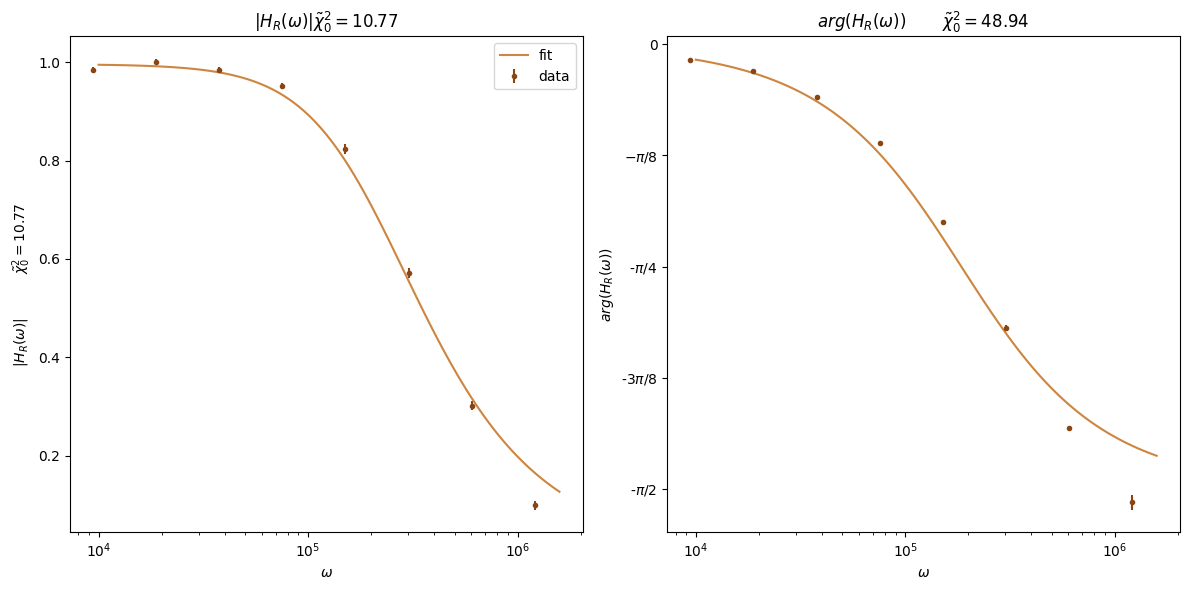

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Modulo HR
x = np.logspace(4, 6.2, 100)
y = mod_HR_f(x, *fit_mod_HR.bval)
axs[0].set_title('$|H_R(\omega)| \t \\tilde{\chi}_0^2=$' + str(fit_mod_HR.rchisquare))
axs[0].errorbar(ω, modHR, yerr=fit_mod_HR.sigmaY, fmt='.', label='data', color='saddlebrown')
axs[0].plot(x, y, label='fit', color='peru')
axs[0].set_xscale('log')
axs[0].set_ylabel('$|H_R(\omega)|$ \t $\\tilde{\chi}_0^2=$' + str(fit_mod_HR.rchisquare))
axs[0].set_xlabel('$\omega$')
axs[0].legend()

# Plot 2: Argomento HR
x = np.logspace(4, 6.2, 100)
y = arg_HR_f(x, *fit_arg_HR.bval)
axs[1].set_title('$arg(H_R(\omega))$ \t $\\tilde{\chi}_0^2=$' + str(fit_arg_HR.rchisquare))
axs[1].errorbar(ω, ΦR, yerr=fit_arg_HR.sigmaY, fmt='.', color='saddlebrown', label='data')
axs[1].plot(x, y, color='peru', label='fit')
axs[1].set_xscale('log')
axs[1].set_ylabel('$arg(H_R(\omega))$')
axs[1].set_xlabel('$\omega$')

axs[1].set_yticks([-np.pi/2,-3*np.pi/8,-np.pi/4,-np.pi/8,0])
axs[1].set_yticklabels(['-$\pi/2$','-$3\pi/8$','-$\pi/4$','$-\pi/8$','0'])


plt.tight_layout()
plt.show()


### FUNZIONE DI TRASFERIMENTO $H_L(\omega)$:

- $|H_L(\omega)| = \frac{\sqrt{R_L^2 + \omega^2 L^2}}{\sqrt{(R+R_L)^2 + \omega^2 L^2}}$
- $\angle H_L(\omega) = arctan(\frac{\omega L}{R_L}) - arctan(\frac{\omega L}{R+R_L})$

In [21]:
# definizione modulo argomento funzione di trasferimento HL

def mod_HL_f(ω, L): # R noto, RL noto
    num = np.sqrt(RL**2 + ω**2 * L**2)
    den2 = (R+RL)**2 + ω**2 * L**2
    return num/np.sqrt(den2)

def arg_HL_f(ω,L):
    return np.arctan(ω*L/RL) -np.arctan(ω*L / (R + RL))

In [22]:
# fit

L_guess =0.04 # usa la resistenza fissata
fit_mod_HL = Interpolazione(ω,modHL,mod_HL_f,sigma_modHL,p0=[L_guess])
fit_arg_HL = Interpolazione(ω,ΦL,arg_HL_f,sigma_ΦL,p0=[L_guess])

print("---------------------------MODULO L-------------------------")
print('chi2: ',fit_mod_HL.rchisquare)
print("---------------------------FASE L-------------------------")
print('chi2: ',fit_arg_HL.rchisquare)
print('------------------------- VALORI RICAVATI DAL FIT MOD HL -----------------------------')
print('L = ',final_val(fit_mod_HL.bval[0],fit_mod_HL.sigma_bval[0],decimals=3,exp=-3,udm='Hr'))
print('------------------------- VALORI RICAVATI DAL FIT ARG HL -----------------------------')
print('L = ',final_val(fit_arg_HL.bval[0],fit_arg_HL.sigma_bval[0],decimals=3,exp=-3,udm='Hr'))

# print('R (nota) = ',final_val(R,sigmaR,decimals=3,exp=3,udm='Ω'))
# print('RL (nota) = ',final_val(RL,sigmaRL,decimals=3,exp=0,udm='Ω'))

---------------------------MODULO L-------------------------
chi2:  8.38
---------------------------FASE L-------------------------
chi2:  42.47
------------------------- VALORI RICAVATI DAL FIT MOD HL -----------------------------
L =  (49.858 ± 1.866)e-3 Hr
------------------------- VALORI RICAVATI DAL FIT ARG HL -----------------------------
L =  (46.785 ± 4.641)e-3 Hr


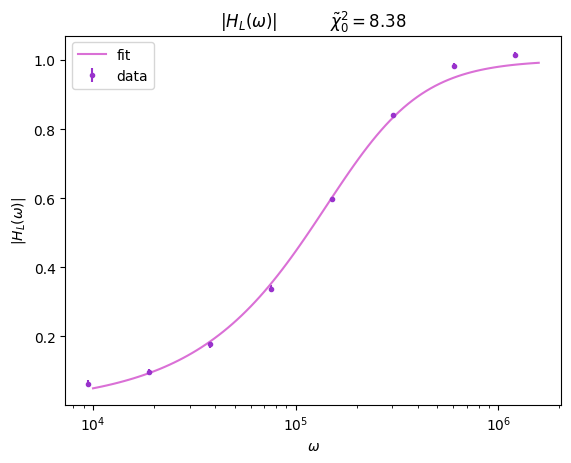

In [23]:
# rappresentazione modulo HL

x = np.logspace(4,6.2,100)
y = mod_HL_f(x,*fit_mod_HL.bval)

plt.title('$|H_L(\omega)|$ \t $\\tilde{\chi}_0^2=$' + str(fit_mod_HL.rchisquare))
plt.errorbar(ω,modHL,yerr=fit_mod_HL.sigmaY,fmt='.',label='data',color='darkorchid')
plt.plot(x,y,label='fit',color='orchid')
plt.xscale('log')
plt.ylabel('$|H_L(\omega)|$')
plt.xlabel('$\omega$')
plt.legend()
plt.show()

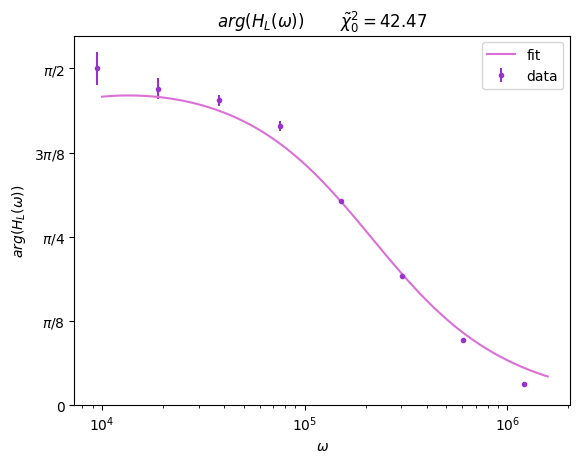

In [24]:
import numpy as np
# rappresentazione argomento HL

x = np.logspace(4,6.2,100)
y = arg_HL_f(x,*fit_arg_HL.bval)

plt.title('$arg(H_L(\omega))$ \t $\\tilde{\chi}_0^2=$' + str(fit_arg_HL.rchisquare))
plt.errorbar(ω,ΦL,yerr=fit_arg_HL.sigmaY,fmt='.',color='darkorchid',label='data')
plt.plot(x,y,label='fit',color='orchid')
yticks = {'$\pi/2$': np.pi/2, '$3\pi/8$': 3*np.pi/8, '$\pi/4$': np.pi/4, '$\pi/8$': np.pi/8,'0':0}
plt.yticks(list(yticks.values()), list(yticks.keys()))
plt.xscale('log')
plt.ylabel('$arg(H_L(\omega))$')
plt.xlabel('$\omega$')
plt.legend()
plt.show()

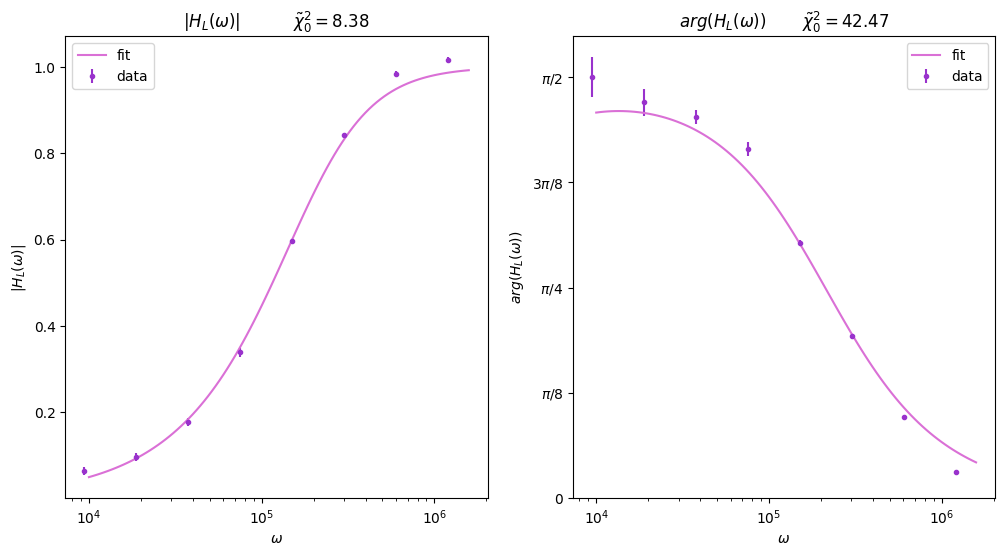

In [25]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 6))

# rappresentazione modulo HL

x = np.logspace(4,6.2,100)
y = mod_HL_f(x,*fit_mod_HL.bval)

ax1.set_title('$|H_L(\omega)|$ \t $\\tilde{\chi}_0^2=$' + str(fit_mod_HL.rchisquare))
ax1.errorbar(ω,modHL,yerr=fit_mod_HL.sigmaY,fmt='.',label='data',color='darkorchid')
ax1.plot(x,y,label='fit',color='orchid')
ax1.set_xscale('log')
ax1.set_ylabel('$|H_L(\omega)|$')
ax1.set_xlabel('$\omega$')
ax1.legend()

# rappresentazione argomento HL

x = np.logspace(4,6.2,100)
y = arg_HL_f(x,*fit_arg_HL.bval)

ax2.set_title('$arg(H_L(\omega))$ \t $\\tilde{\chi}_0^2=$' + str(fit_arg_HL.rchisquare))
ax2.errorbar(ω,ΦL,yerr=fit_arg_HL.sigmaY,fmt='.',color='darkorchid',label='data')
ax2.plot(x,y,label='fit',color='orchid')
ax2.set_xscale('log')
ax2.set_ylabel('$arg(H_L(\omega))$')
ax2.set_xlabel('$\omega$')
ax2.set_yticks([np.pi/2,3*np.pi/8,np.pi/4,np.pi/8,0])
ax2.set_yticklabels(['$\pi/2$','$3\pi/8$','$\pi/4$','$\pi/8$','0'])
ax2.legend()

plt.show()

# STIMA VALORE L con CONFRONTO

avendo calcolato il valore di L con differenti interpolazioni le confrontiamo mediandole per calcolare il suo valore

In [26]:
L = np.array([fit_arg_HL.bval[0], fit_mod_HL.bval[0], fit_mod_HR.bval[0], fit_arg_HR.bval[0]])
sigmaL = np.array([fit_arg_HL.sigma_bval[0], fit_mod_HL.sigma_bval[0], fit_mod_HR.sigma_bval[0], fit_arg_HR.sigma_bval[0]])
w = 1/(sigmaL**2)
L_avg = np.average(L, weights=w)
sigmaL_avg = np.sqrt(1/np.sum(w))

print('< L > = ', final_val(L_avg, sigmaL_avg, decimals=3, exp=-3, udm='Hr'))


< L > =  (49.624 ± 1.431)e-3 Hr
